In [2]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [3]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Rare Functional Variant Summary analysis</h2>

In [5]:
variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter on human variants
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "

human_variant_df = variant_df.query(filter_query).copy()
human_variant_df_filtered = variant_df_filtered.query(filter_query).copy()

human_variant_df['delta_logodds_pred'] = human_variant_df['mean_delta_logodds_pred']
human_variant_df_filtered['delta_logodds_pred'] = human_variant_df_filtered['mean_delta_logodds_pred']


var_df = human_variant_df_filtered.query("variant == 'snv' and snv_pos != -1").copy()

mer6_weights_doubledope = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_doubledope_weights.npy')[1:]
mer6_weights_simple = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_simple_weights.npy')[1:]
mer6_weights_tomm5 = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_tomm5_weights.npy')[1:]

mer6_weights_use = (mer6_weights_tomm5[:4096] + mer6_weights_simple[:4096]) / 2.
mer6_weights_pas = mer6_weights_doubledope[4096:2*4096]
mer6_weights_dse = (mer6_weights_tomm5[2*4096:] + mer6_weights_simple[2*4096:]) / 2.

var_df = append_6mer_delta_logodds_scores(var_df, mer6_weights_use, mer6_weights_pas, mer6_weights_dse)
var_df['delta_logodds_pred'] = var_df['mean_delta_logodds_pred']


n variants = 12348
n variants (stat. signi.) = 3771
n variants (stat. signi. & strong preds) = 2330
n variants (stat. signi. & strong preds & correct APARENT) = 2180
n variants (stat. signi. & strong preds & disagree) = 257


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


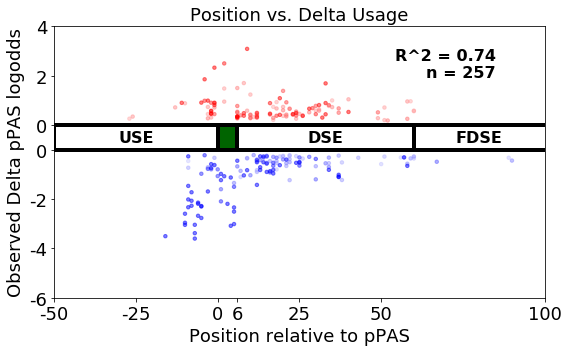

n variants (stat. signi. & strong preds & disagree) = 35


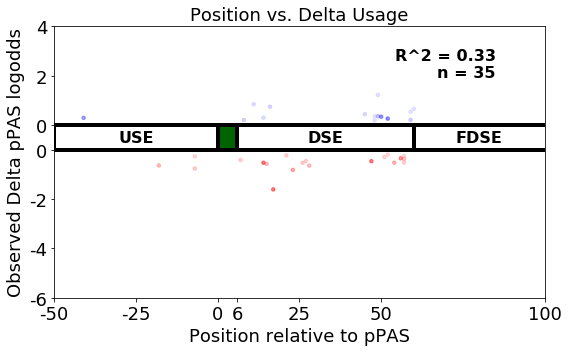

In [6]:
save_figs = False

p_thresh = 0.00001

print('n variants = ' + str(len(var_df)))

#Filter on significant variants
discrep_index = (var_df['delta_p_val'] < p_thresh)
print('n variants (stat. signi.) = ' + str(len(var_df.loc[discrep_index])))

#Filter on > 0.1 predicted log fold change
discrep_index = discrep_index & (np.abs(var_df['delta_6mer_score']) > 0.11)
discrep_index = discrep_index & (np.abs(var_df['delta_logodds_pred']) > 0.115)
print('n variants (stat. signi. & strong preds) = ' + str(len(var_df.loc[discrep_index])))

#Calculate the number of correctly predicted variants (using APARENT)
discrep_index_correct = discrep_index & (np.sign(var_df['delta_logodds_true']) == np.sign(var_df['delta_logodds_pred']))
print('n variants (stat. signi. & strong preds & correct APARENT) = ' + str(len(var_df.loc[discrep_index_correct])))

#Filter on sign of APARENT prediction not equal to sign of hexamer predictions, APARENT correct
discrep_index = discrep_index & ((np.sign(var_df['delta_logodds_true']) != np.sign(var_df['delta_6mer_score'])) & (np.sign(var_df['delta_logodds_true']) == np.sign(var_df['delta_logodds_pred'])))
print('n variants (stat. signi. & strong preds & disagree) = ' + str(len(var_df.loc[discrep_index])))

#Plot position scatter of variants
discrep_df = var_df.iloc[np.nonzero(discrep_index)[0]].copy()
fig_name = None
if save_figs :
    fig_name = 'rare_variants_neural_net_agrees_with_obs'
plot_position_delta_scatter(discrep_df, min_pred_filter=0.0, figsize=(8, 5), fig_name=fig_name, fig_dpi=150, annotate=None)

discrep_index = (var_df['delta_p_val'] < p_thresh)
discrep_index = discrep_index & (np.abs(var_df['delta_6mer_score']) > 0.11)
discrep_index = discrep_index & (np.abs(var_df['delta_logodds_pred']) > 0.115)

#Filter on sign of APARENT prediction not equal to sign of hexamer predictions, hexamer model correct
discrep_index = discrep_index & ((np.sign(var_df['delta_logodds_true']) == np.sign(var_df['delta_6mer_score'])) & (np.sign(var_df['delta_logodds_true']) != np.sign(var_df['delta_logodds_pred'])))
print('n variants (stat. signi. & strong preds & disagree) = ' + str(len(var_df.loc[discrep_index])))

discrep_df = var_df.iloc[np.nonzero(discrep_index)[0]].copy()

#Plot position scatter of variants
fig_name = None
if save_figs :
    fig_name = 'rare_variants_6mer_model_agrees_with_obs'
plot_position_delta_scatter(discrep_df, min_pred_filter=0.0, figsize=(8, 5), fig_name=fig_name, fig_dpi=150, annotate=None)
